In [2947]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import joblib

# Version Register
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Joblib version:", joblib.__version__)
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)

Python version: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Numpy version: 1.26.2
Pandas version: 2.1.4
TensorFlow version: 2.15.0
Scikit-learn version: 1.3.2
Joblib version: 1.3.2
Seaborn version: 0.13.0
Matplotlib version: 3.8.2


## Dataset

The first step in creating a Machine Learning model is to load in the dataset used in the problem. In the code cell below, you can see that we load in the csv file containing the training data. The PassangerId is set as the dataframe index and the first five rows are displayed.

In [2948]:
# Load the training set
df = pd.read_csv(os.path.join('data', 'train.csv'))

# Set 'PassengerId' as the index for both DataFrames
df.set_index('PassengerId', inplace=True)

# Display the first few rows of the combined DataFrame
display(df.head())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Checking for 'NaN' values

A good practise is to always check for NaN values in your data. In my solution, I have checked for the percentage of NaN entries in each column to detirmine how I want to fix the issue.

As visible from the output, the age column contains quite a lot of NaN values, but because my hypothesis is that it is an important classifier, I will be solving it by filling in the missing values with the mean. Filling the values with the mean is a popular and effective approach for numerical data. Same goes for 'Fare'

Cabin might be an interesting classifier, but in it's current state it is completely ineffective. The first problem is the fact that 77.1% of the people did not have a cabin, but even in the people who had a cabin, the decks were on different stories of the boat, making escape from deck 'G' significantly harder than escaping from deck 'A'. To fix this, I will be classifying every person without a deck as 0, A as 1, B as 2 and so forth. This way, the general cabin location can be used as categorical data.

Embarked is to be studied upon furthur, but a measure of wealth might be connected to the origin of a person. Due to this reason I will be turning this into categorical data and then I will be filling the 'NaN' entries with the most popular value (mode).

In [2949]:
# Calculate the percentage of rows with NaN values for each column
nan_percentage = df.isna().mean() * 100

# Display the percentage of rows with NaN values
print("\nPercentage of rows with NaN values for each column:")
print(nan_percentage)


Percentage of rows with NaN values for each column:
Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64


### Dropping Useless Information

Some information might be unusable in a dataset and in this case, I deemed the names of people to be unnecessary, as it does not provide any value in wether a person might survive in the end. Same goes for the ticked value, because the ticket value seems to have too much randomness going for it to be preprocessed into a usefull feature.

In [2950]:
# Drop the unusable columns
df.drop('Name', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)

# Display the first few rows of the DataFrame
display(df.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S
2,1,1,female,38.0,1,0,71.2833,C85,C
3,1,3,female,26.0,0,0,7.9250,NaN,S
4,1,1,female,35.0,1,0,53.1000,C123,S
5,0,3,male,35.0,0,0,8.0500,NaN,S


### Preprocessing 'Sex'

The first value that needs to be represented differently is sex. The sex should be represented as a categorical field where male is 0, female is 1. From inspecting the dataset, we can conclude that there are no missing values and that the sex is either male or female. 

In [2951]:
# Map 'male' to 0 and 'female' to 1 in the 'Sex' column
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Display the new header
display(df.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,NaN,S
2,1,1,1,38.0,1,0,71.2833,C85,C
3,1,3,1,26.0,0,0,7.9250,NaN,S
4,1,1,1,35.0,1,0,53.1000,C123,S
5,0,3,0,35.0,0,0,8.0500,NaN,S


### Preprocessing 'Cabin'

The process of preprocessing Cabin was described earlier together with the choice in why I wanted to preprocess this data using this method.

In [2952]:
# Extract the first letter (deck) from 'Cabin'
df['Cabin'] = df['Cabin'].str[0]

# Map each deck to a numeric value
deck_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

# Map 'CabinDeck' column and set to 0 for values not in the deck_mapping keys
df['Cabin'] = df['Cabin'].map(deck_mapping).fillna(0)

# Convert 'CabinDeck' column to integer type
df['Cabin'] = df['Cabin'].astype(int)

# Display the new header
display(df.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,0,S
2,1,1,1,38.0,1,0,71.2833,3,C
3,1,3,1,26.0,0,0,7.9250,0,S
4,1,1,1,35.0,1,0,53.1000,3,S
5,0,3,0,35.0,0,0,8.0500,0,S


### Preprocessing 'Embarked'

In this code cell, the missing values for 'Embarked' were handled as explained before. Now the data is ready to be one hot encoded.

In [2953]:
# Convert 'Embarked' to categorical data
df['Embarked'] = df['Embarked'].astype('category')

# Fill NaN entries in 'Embarked' with the mode
mode_embarked = df['Embarked'].mode()[0]
df['Embarked'].fillna(mode_embarked, inplace=True)

# Display the updated DataFrame
display(df.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,0,S
2,1,1,1,38.0,1,0,71.2833,3,C
3,1,3,1,26.0,0,0,7.9250,0,S
4,1,1,1,35.0,1,0,53.1000,3,S
5,0,3,0,35.0,0,0,8.0500,0,S


### Preprocessing 'Numerical Data'

Before scaling, I handled the missing values in Age.

To scale the numerical data, I chose to use RobustScaling to handle cases of extreme values in the data. After scaling a column, I also saved the scaler for future use of the model.

In [2954]:
# Filling in the NaN values in Age
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Fare'].fillna(df['Fare'].mean(), inplace=True)

# Specify the columns with numerical data
numerical = ['Age', 'Fare']

# Specify the folder to store scaler instances
preprocessing_folder = 'preprocessors'

# Create the folder if it doesn't exist
os.makedirs(preprocessing_folder, exist_ok=True)

# Create a dictionary to store scaler instances
scalers = {}

# Create and save scaler instances for 'Age' and 'Fare' using RobustScaler
for col in numerical:
    scaler = RobustScaler()
    df[col] = scaler.fit_transform(df[[col]])
    
    # Save the scaler to a file in the 'preprocessing' folder
    scaler_filename = os.path.join(preprocessing_folder, f'{col}_scaler.joblib')
    joblib.dump(scaler, scaler_filename)
    
    # Store the scaler instance in the dictionary
    scalers[col] = scaler_filename

# Display the new header
display(df.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,0,-0.592240,1,0,-0.312011,0,S
2,1,1,1,0.638529,1,0,2.461242,3,C
3,1,3,1,-0.284548,0,0,-0.282777,0,S
4,1,1,1,0.407760,1,0,1.673732,3,S
5,0,3,0,0.407760,0,0,-0.277363,0,S


### Preprocessing 'Categorical Data'

To use categorical data in a neural network, it needs to be one hot encoded. To do this, we simply use the One hot encoder from sklearn, which we can also store for later use.

In [2955]:
# Specify the columns with categorical data
categorical_columns = ['Pclass', 'Embarked', 'Cabin']

# Create and fit the OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
onehot_encoder.fit(df[categorical_columns])

# Save the scaler to a file in the 'preprocessing' folder
onehot_encoder_filename = os.path.join(preprocessing_folder, f'onehot_encoder.joblib')
joblib.dump(onehot_encoder, onehot_encoder_filename)

# Transform the categorical columns
onehot_encoded = onehot_encoder.transform(df[categorical_columns]).toarray()

# Separate the combined dataset back into training and test (or future) datasets
df_encoded = pd.DataFrame(onehot_encoded[:len(df)])

# Display the updated training and test (or future) DataFrames
display(df_encoded.head())

# Drop the columns from the original dataframe
df.drop(categorical_columns, axis=1, inplace=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Extracting the Features and Labels

The final step in preprocessing is to extract the Labels and Features and also to split them into train and test data. The split is done at the standard 70% to 30% ratio while developing the model and tweaking the preprocessing.

In [2956]:
# Extract the 'Survived' column as the labels
Y = df['Survived'].to_numpy()
df.drop('Survived', axis=1, inplace=True)
print("Labels (Y) shape:", Y.shape)

# Concatenate the original and encoded DataFrames into a single NumPy array
X = np.concatenate([df.to_numpy(), df_encoded.to_numpy()], axis=1)
print("Features (X) shape:", X.shape)

# Set test_size according to your desired split ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Labels (Y) shape: (891,)
Features (X) shape: (891, 19)


## Neural Network

Now that the data is preprocessed, all that's left is to make a Neural Network that can handle the input and create an output. The Neural Network will be tested and plotted to view how it performed.

### Model

In this code cell, you can see a basic Neural Network with one hidden layer and a dropout layer to combat overfitting. The final layer is a single neuron with the sigmoid activation in order for it to represent a value between 0 and 1 indicating the certainty of the model thinking the person survived.

In [2957]:
# Create a neural network model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Training

During the fitting process, backpropagation is performed to adjust the weights of the neurons in my model. This causes the neurons to use patterns in the data to make conclusions. The error, or in other words, loss is used to adjust the weights of the neurons and indicates how far the model was from predicting the correct value.

The reason why loss is used for measuring error and not accuracy, is because the model can guess 0.51 for a person who survived. This would technically give a correct classification, but the closer the guess is to 0 or 1, the better, because that would indicate certainty.

In [2958]:
# Train the model with validation data
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/10


20/20 [==============================] - 1s 9ms/step - loss: 0.6759 - accuracy: 0.6308 - val_loss: 0.6027 - val_accuracy: 0.7239
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.6950 - val_loss: 0.5636 - val_accuracy: 0.7164
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5861 - accuracy: 0.7079 - val_loss: 0.5277 - val_accuracy: 0.7836
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5386 - accuracy: 0.7592 - val_loss: 0.5020 - val_accuracy: 0.7910
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5252 - accuracy: 0.7737 - val_loss: 0.4803 - val_accuracy: 0.8172
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5122 - accuracy: 0.7753 - val_loss: 0.4629 - val_accuracy: 0.8209
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4811 - accuracy: 0.8058 - val_loss: 0.4500 - val_accuracy: 0.8060
Epoch 8/10
20/20 [=============

### Testing

To measure how well my model is performing, a test set is used to measure how well the model is at making guesses on data that it has not seen before. In my case I have been using the testing set as the validation set aswell, due to the scarcity of the data, but the validation set is also not used for adjusting the weights and this allows me to make adjustments for overfitting.

In [2959]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)

# Print the test loss and accuracy
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Loss: 0.4291
Test Accuracy: 81.34%


### Train/Validation Plots

In the plots below is visible how well my model was performing over epochs, when I diagnosed overfitting, I lowered the amount of epochs that my model trained for and perfected the numbers of neurons and epochs.

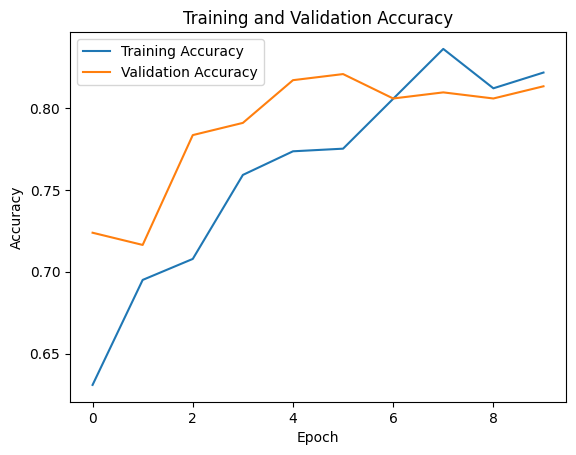

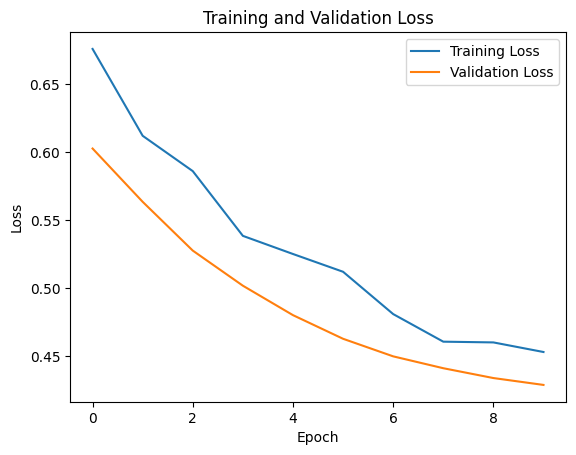

In [2960]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Confusion Matrix

A common practise in Machine Learning is to display the results in a confusion matrix. Besides that, the precision and recall are also common classifiers that can be used to diagnose balance issues in training data which are printed below the confusion matrix.

As you can see in the metrics, the model classifies true survivors quite well to survive. The only problem is that the model seems to predict only 70.27% of the non-survivors accuratly as you can see in the confusion matrix and recall.

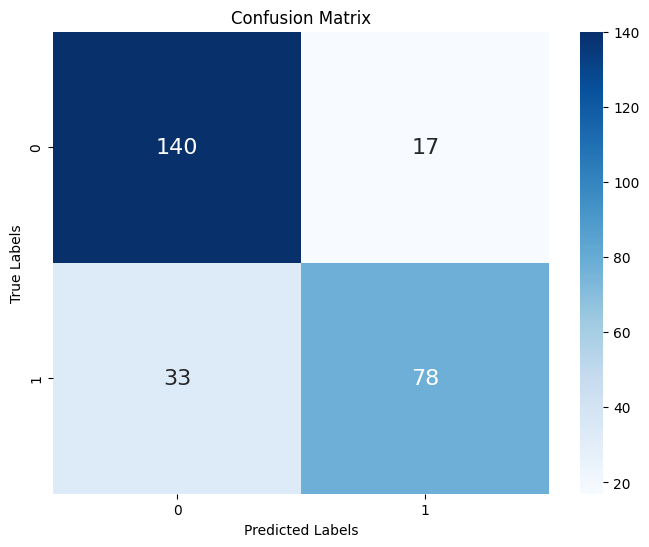

Precision: 0.8211
Recall: 0.7027


In [2961]:
# Predict labels for the test set
Y_pred = model.predict(X_test, verbose=0)
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(Y_test, Y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate precision and recall
precision = precision_score(Y_test, Y_pred_binary)
recall = recall_score(Y_test, Y_pred_binary)

# Print precision and recall
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')